In [1]:
import argparse
from model import CNN, SimpleResNet
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from fmnist_dataset import load_fashion_mnist, FashionMNISTDataset
from torch.utils.data import DataLoader
import random
import numpy as np
from train import evaluate, trainEpochs
import matplotlib.pyplot as plt
import pickle
from torch.distributions.multivariate_normal import MultivariateNormal
import logging
import sys
import datetime

In [2]:
#对抗样本生成超参数
EPSILON = 64
ALPHA = 1.0

In [3]:
class WhiteBoxAttacker():
    def __init__(self, model, epsilon, alpha) -> None:
        self.model = model
        self.epsilon = epsilon
        self.alpha = alpha

    def clip(self, x_updated, x):
        # element-wise clipping
        return torch.minimum( torch.minimum(x + self.epsilon, torch.full_like(x, 255)), torch.maximum(torch.full_like(x, 0), torch.maximum(x - self.epsilon, x_updated)))

    def attack(self, model, x, y_target):
        # reference: ADVERSARIAL EXAMPLES IN THE PHYSICAL WORLD, ICLR 2017
        # x: (batch_size, 1, 28, 28) FloatTensor
        # y_target : (batch_size) LongTensor
        model.eval()
        x_updated = x
        step_n = int(min(self.epsilon+4, self.epsilon*1.25))
        for step in range(step_n):
            x_updated.requires_grad_()
            logits = model(x_updated)
            loss = F.cross_entropy(logits, y_target)
            x_grad = torch.autograd.grad(loss, x_updated)[0].detach().clone()
            x_updated = self.clip(x_updated.detach() - self.alpha * torch.sign(x_grad), x)
            
        return x_updated.detach()

In [4]:
def generate_adversarial_examples(attacker, test_dataloader, example_n = None):
    model = attacker.model
    model.eval()

    x_correct = []
    y_correct = []

    for batch in test_dataloader:
        x, y = batch
        x, y = x.cuda(), y.cuda()
        logits = model(x)

        correct_index = (torch.argmax(logits, dim=1) == y)
        x_correct.append(x[correct_index])
        y_correct.append(y[correct_index])
    
    x_correct = torch.concatenate(x_correct, dim=0)
    y_correct = torch.concatenate(y_correct, dim=0)

    if example_n:
        # sample 1000 examples
        random_sample = torch.LongTensor(np.random.choice(len(x_correct), example_n, replace=False))
        x_correct = x_correct[random_sample]
        y_correct = y_correct[random_sample]
    else:
        pass

    correct_dataset = FashionMNISTDataset((x_correct, y_correct))
    correct_loader = DataLoader(correct_dataset, batch_size=50, shuffle=False)

    x_adv = []
    for batch in correct_loader:
        x, y = batch
        x, y = x.cuda(), y.cuda()
        y_target = (y + 1) % 10 
        adversarial_examples = attacker.attack(model, x, y_target)
        x_adv.append(adversarial_examples)
    
    # x_adv : (1000, embed_dim)
    x_adv = torch.concat(x_adv, dim=0)
    y_adv = (y_correct + 1) % 10

    return x_correct, y_correct, x_adv, y_adv

In [5]:
def success_rate_with_examples(model, x_adv, y_adv, example_n = 10):
    model.eval()
    dataloader = DataLoader(FashionMNISTDataset((x_adv, y_adv)), batch_size=50, shuffle=False)
    correct_n = 0
    total_n = 0
    offset = 0

    success_indicies = []

    for batch in dataloader:
        x, y = batch
        x, y = x.cuda(), y.cuda()
        logits = model(x)

        success_index = torch.nonzero((torch.argmax(logits, dim=1) == y), as_tuple=False)
        success_indicies.append(success_index + offset)
        offset += len(y)

        correct_n += (torch.argmax(logits, dim=1) == y).sum().item()
        total_n += len(y)
    
    attack_success_rate = correct_n / total_n
    success_indicies = torch.concat(success_indicies, dim=0).squeeze()
    random_sample = torch.LongTensor(np.random.choice(len(success_indicies), example_n, replace=False))


    return attack_success_rate*100, success_indicies[random_sample]

def save_image(x_correct, y_correct, x_adv, y_adv, success_indicies, image_path, image_name):

    for i in range(len(success_indicies)):
        original_image = x_correct[success_indicies][i].reshape([28, 28]).cpu().numpy()
        original_label = y_correct[success_indicies][i].cpu().numpy()
        adversarial_image = x_adv[success_indicies][i].reshape([28, 28]).cpu().numpy()
        adversarial_label = y_adv[success_indicies][i].cpu().numpy()
        fig, axs = plt.subplots(1,2, figsize=(10, 20))
        axs[0].imshow(original_image)
        axs[0].set_title("Original Image (label = {})".format(original_label))
        axs[1].imshow(adversarial_image)
        axs[1].set_title("Adversarial Image (label = {})".format(adversarial_label))
        fig.tight_layout()
        fig.savefig("{}/{}_{}".format(image_path, image_name, i)) # fmnist_white_box_attack_example

In [6]:
#超参数设置
parser = argparse.ArgumentParser()
class OPT():
    def __init__(self) -> None:
        self.save_dir = 'new_resnet_checkpoints'
        self.dataset_dir = '../data'
        self.batch_size = 64
        self.eval_batch_size = 1000
        self.num_epochs = 20
        self.learning_rate = 2e-4
        self.rand_seed = 42
        self.log_per_step = 100
opt = OPT()
torch.manual_seed(opt.rand_seed)
torch.cuda.manual_seed(opt.rand_seed)
random.seed(opt.rand_seed)
np.random.seed(opt.rand_seed)
device = "cuda"

SimpleResNet test_accuracy : 90.250%
white-box attack success rate on SimpleResNet: 97.700%
example images were saved successfully


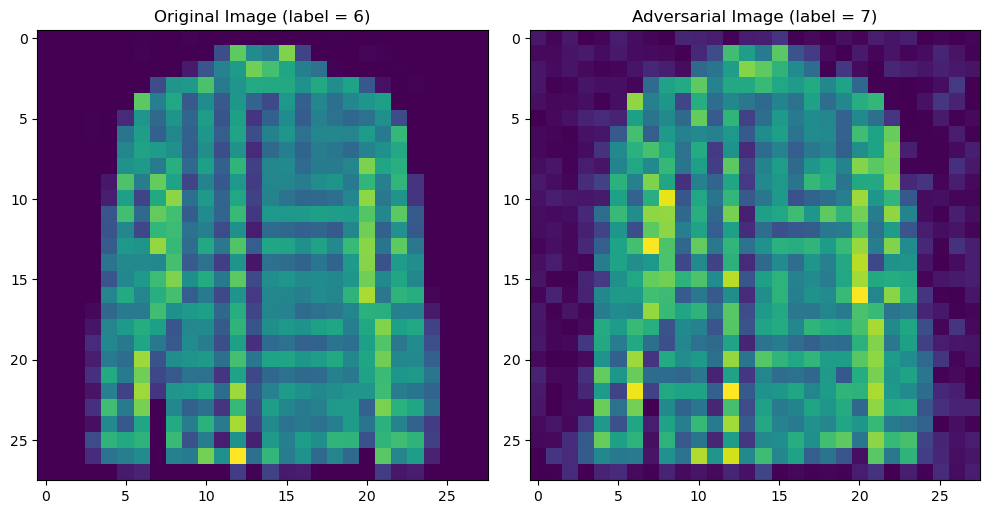

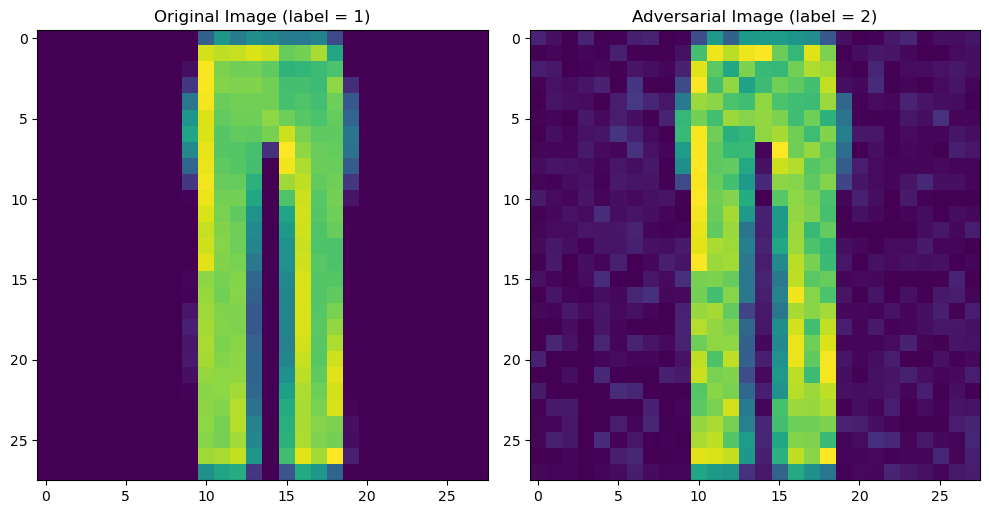

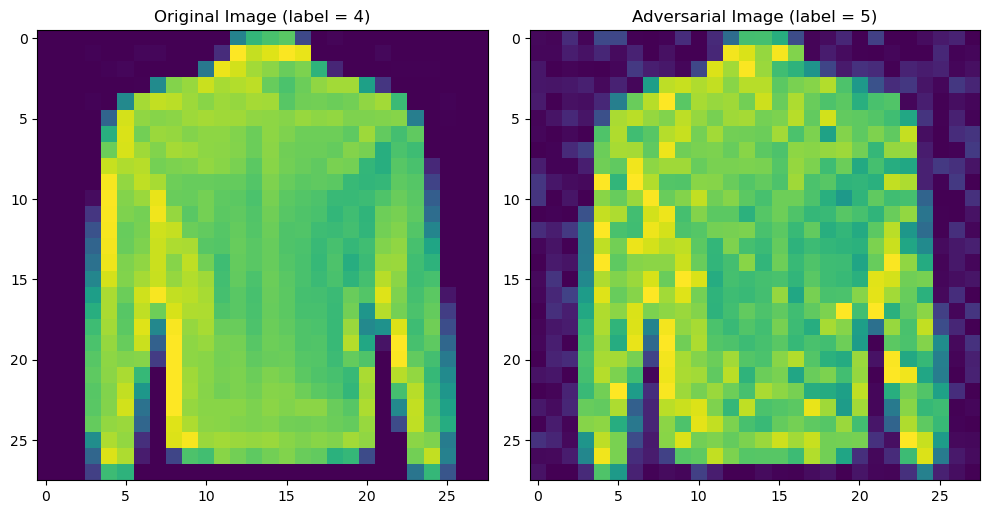

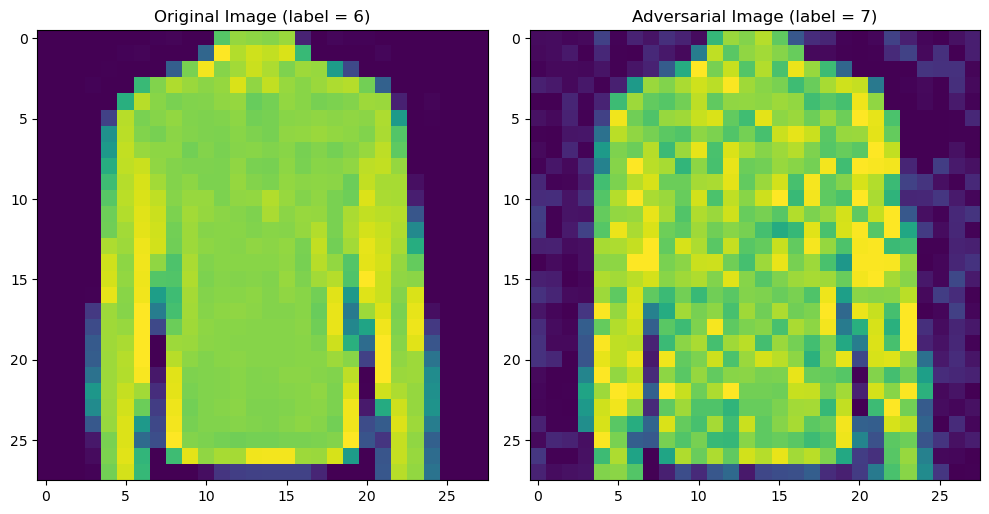

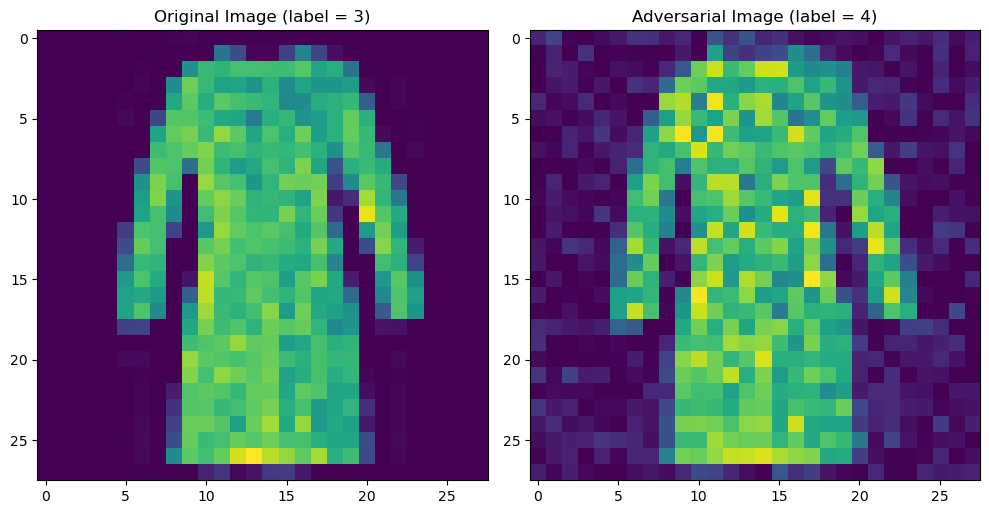

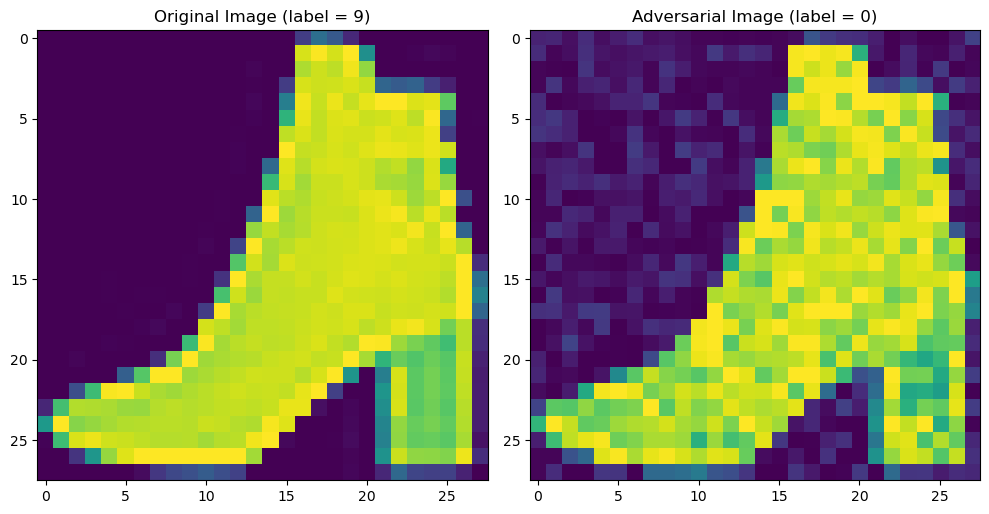

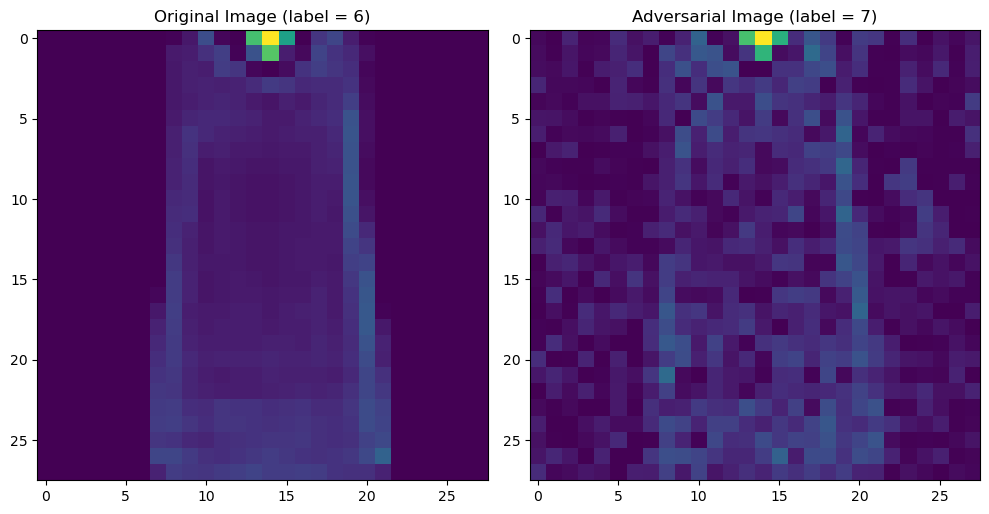

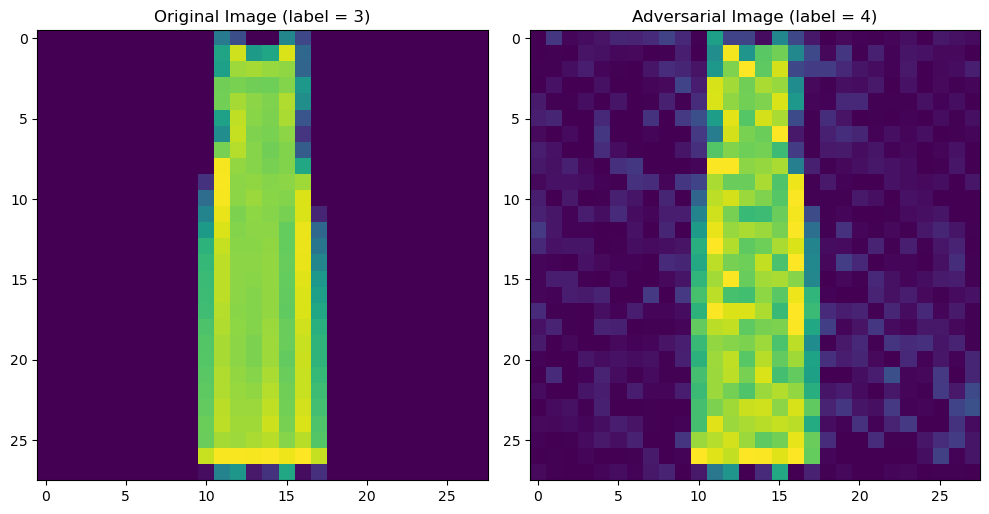

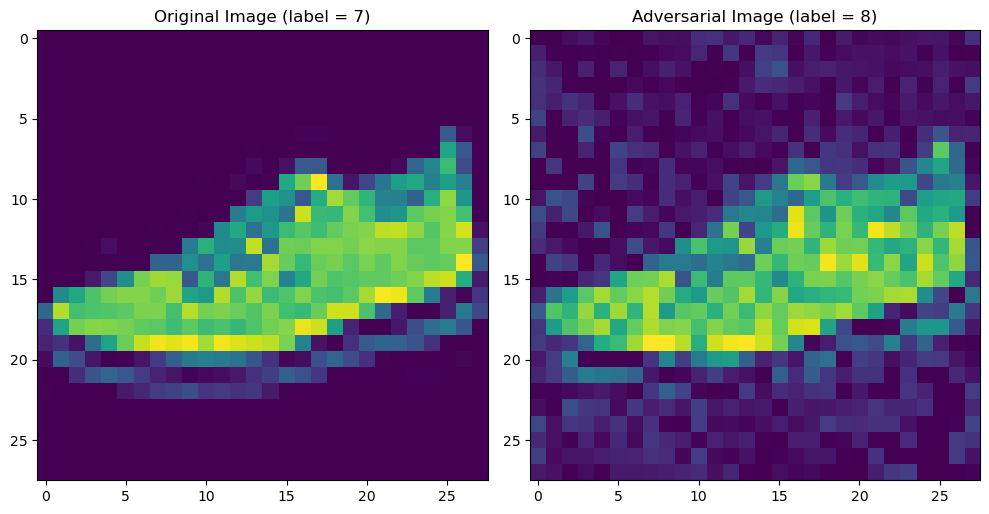

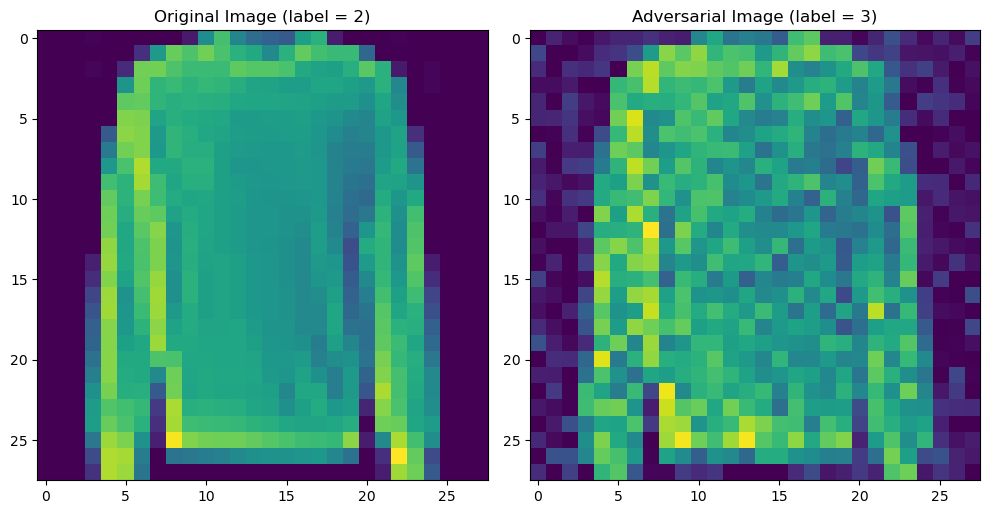

In [11]:
### III-B：白盒攻击
white_model = SimpleResNet().cuda() #SimpleResNet 分类器的源码请见model.py
checkpoint_path = 'resnet_checkpoints/ep_20_devacc_90.72_.pt'
white_model.load_state_dict(torch.load(checkpoint_path))
attacker = WhiteBoxAttacker(white_model, epsilon=EPSILON, alpha=ALPHA)
_, _, test = load_fashion_mnist("../data", random=random)
test_dataloader = DataLoader(test, batch_size=opt.batch_size)
test_accuracy = evaluate(white_model, test_dataloader, 'cuda')
print("{} test_accuracy : {:.3f}%".format(type(white_model).__name__, test_accuracy))
x_correct, y_correct, x_adv, y_adv = generate_adversarial_examples(attacker, test_dataloader, example_n = 1000)
white_attack_success_rate, success_indicies = success_rate_with_examples(white_model, x_adv, y_adv, example_n = 10)
print("white-box attack success rate on {}: {:.3f}%".format(type(white_model).__name__, white_attack_success_rate))
save_image(x_correct, y_correct, x_adv, y_adv, success_indicies, image_path='images/image_old_white_box', image_name='fmnist_white_box_attack_example')
print("example images were saved successfully")

black-box attack success rate on CNN: 2.261%
example images were saved successfully


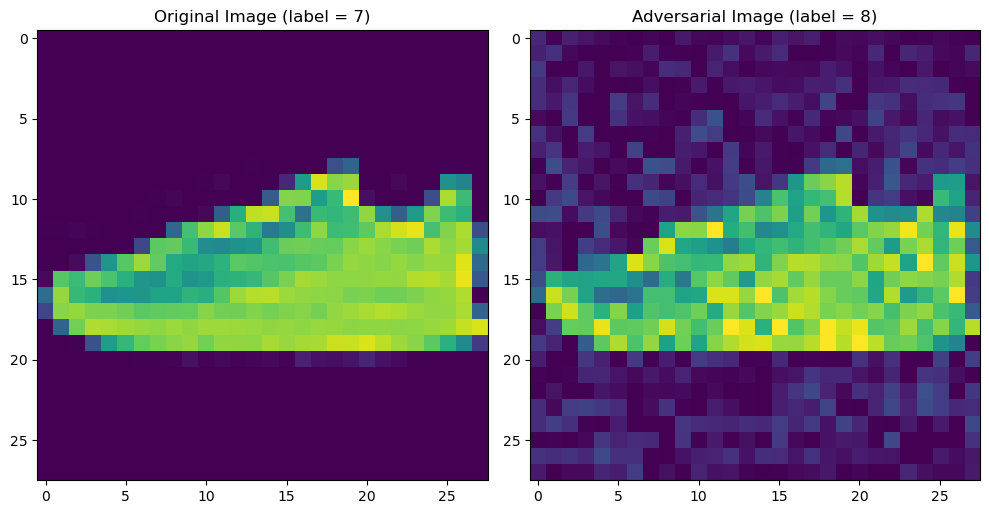

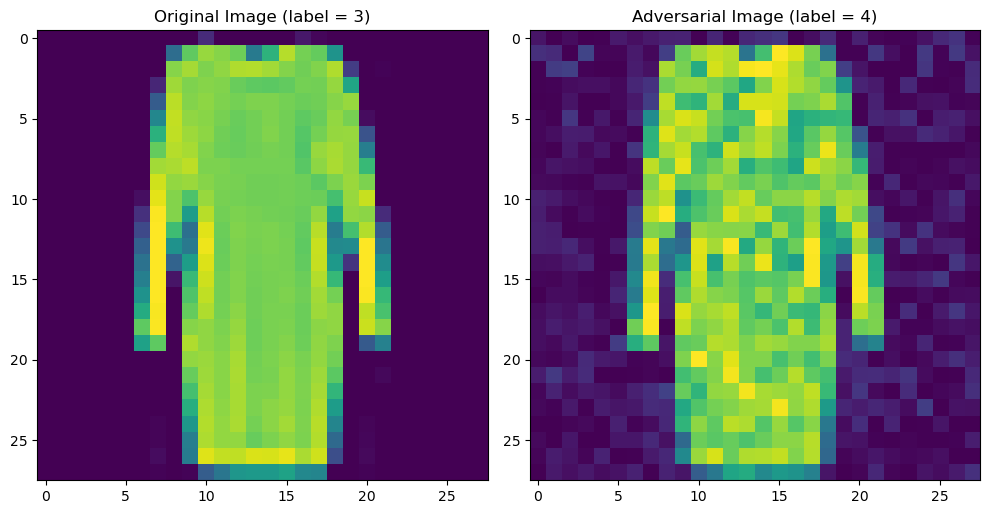

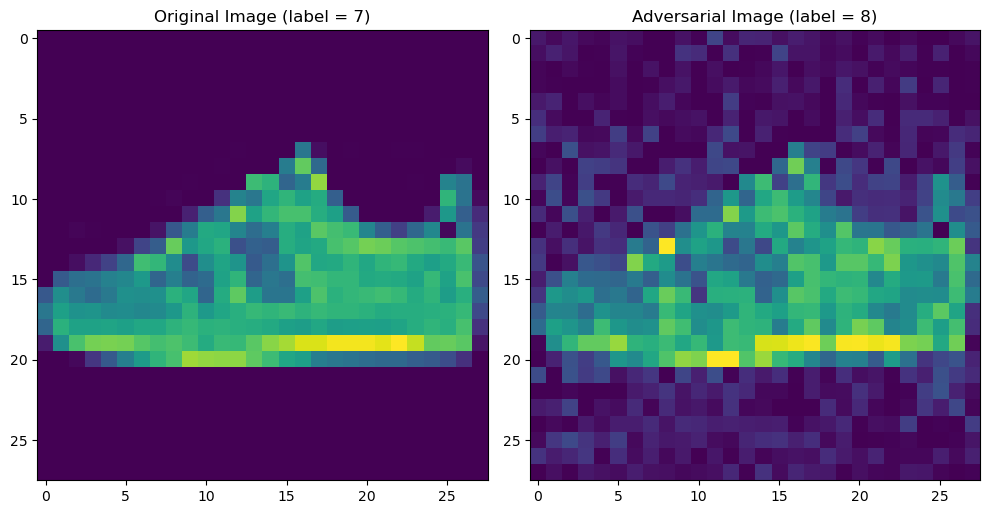

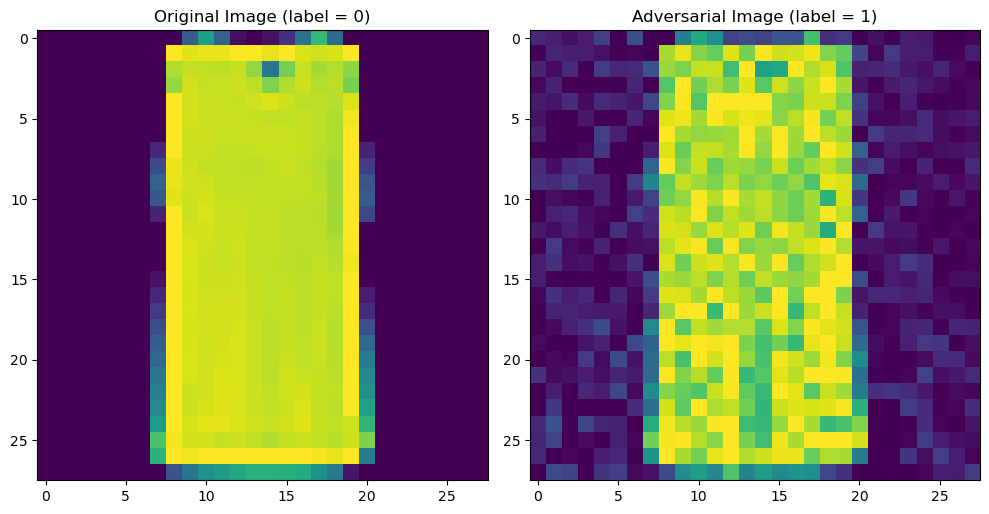

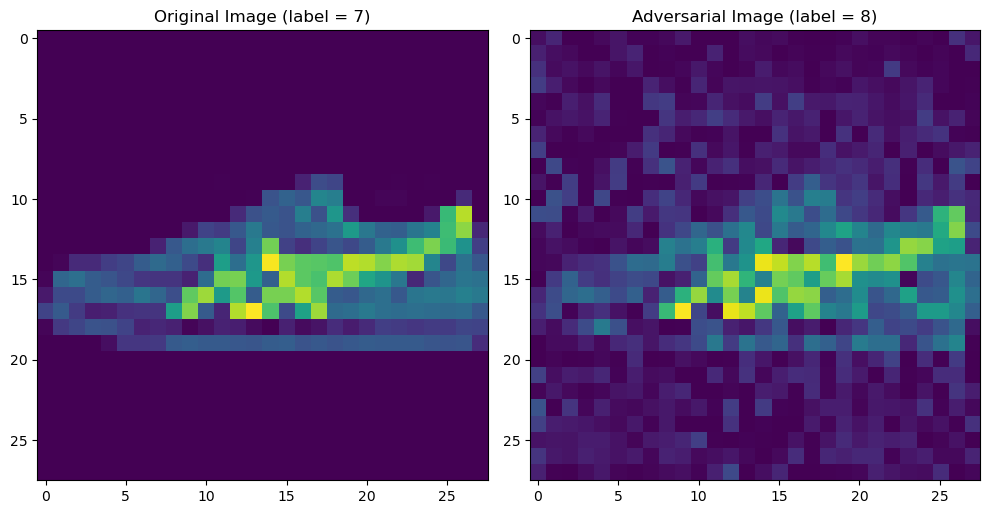

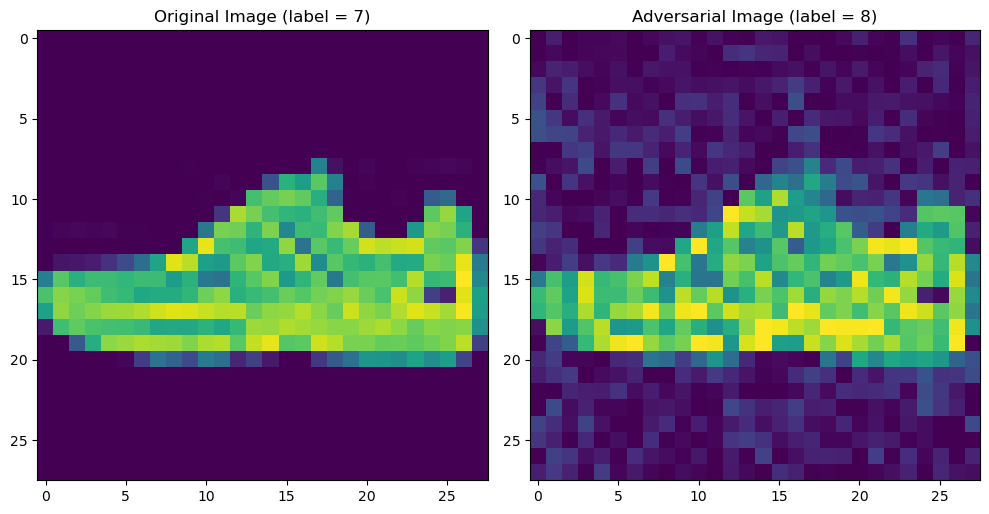

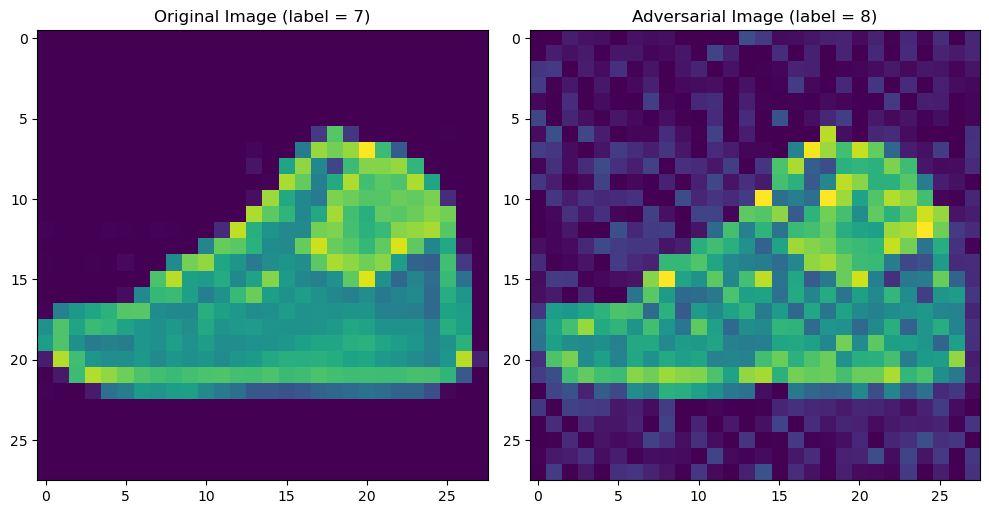

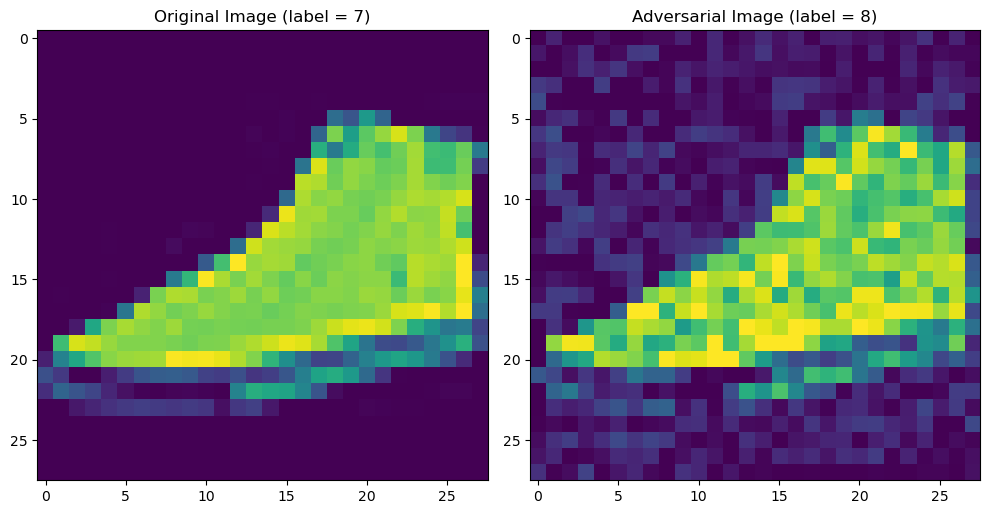

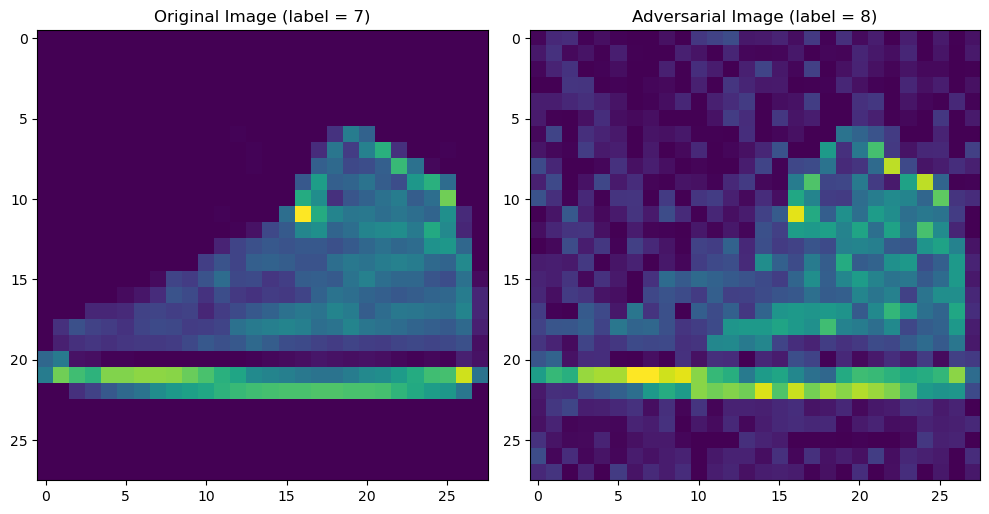

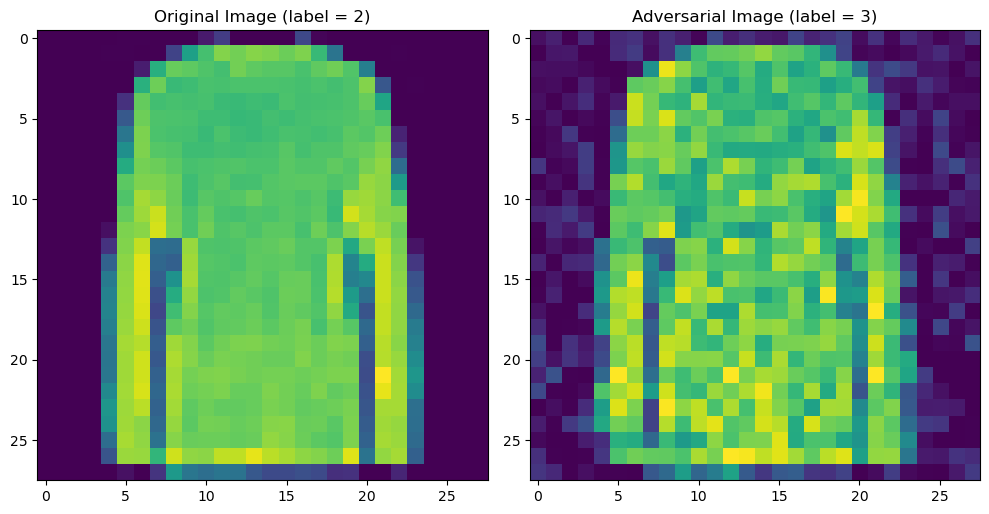

In [12]:
### III-C：黑盒攻击 #################################
## white_model是白盒模型，通过白盒模型产生对抗样本，将对抗样本迁移至黑盒模型进行测试
attacker = WhiteBoxAttacker(white_model, epsilon=EPSILON, alpha=ALPHA)

# 黑盒模型
black_model = CNN().cuda()
checkpoint_path = '../model/cnn.ckpt'
black_model.load_state_dict(torch.load(checkpoint_path))

#black box data
import pickle
with open('../attack_data/correct_1k.pkl', 'rb') as f:
    data = pickle.load(f)
    x = data[0]
    y = data[1]
    x = np.stack(x)
    y = np.stack(y)
    blackbox_data = (x, y)
blackbox_dataloader = DataLoader(FashionMNISTDataset(blackbox_data), batch_size=opt.batch_size)
x_correct, y_correct, x_adv, y_adv = generate_adversarial_examples(attacker, blackbox_dataloader, example_n = None)
black_attack_success_rate, success_indicies = success_rate_with_examples(black_model, x_adv, y_adv, example_n = 10)
print("black-box attack success rate on {}: {:.3f}%".format(type(black_model).__name__, black_attack_success_rate))
save_image(x_correct, y_correct, x_adv, y_adv, success_indicies, image_path='images/image_old_black_box', image_name='fmnist_black_box_attack_example')
print("example images were saved successfully")

In [13]:
### III-D：对抗训练
attacker = WhiteBoxAttacker(white_model, epsilon=EPSILON, alpha=ALPHA)
train, dev, test = load_fashion_mnist("../data", random=random)
train_dataloader = DataLoader(train, batch_size=opt.batch_size)
dev_dataloader = DataLoader(dev, batch_size=opt.eval_batch_size)
# 在训练集上生成对抗样本
x_correct, y_correct, x_adv, y_adv = generate_adversarial_examples(attacker, train_dataloader, example_n = 1000)
# 将对抗样本掺入训练集中
x_train_org, y_train_org = train.x, train.y
x_train_org, y_train_org = torch.FloatTensor(x_train_org).cuda(), torch.LongTensor(y_train_org).cuda()
x_train_aug, y_train_aug = torch.concat([x_train_org, x_adv], dim=0), torch.concat([y_train_org, y_correct], dim=0)
train_aug = [x_train_aug, y_train_aug]
augmented_train_dataloader = DataLoader(FashionMNISTDataset(train_aug), batch_size=opt.batch_size)

In [20]:
# 重新训练设置完全相同的网络
new_white_model = SimpleResNet().cuda()
optimizer = optim.Adam(new_white_model.parameters(), lr=opt.learning_rate)
criterion = nn.CrossEntropyLoss()
trainEpochs(new_white_model, optimizer, criterion, opt.num_epochs,
            augmented_train_dataloader, dev_dataloader,
            opt.log_per_step, opt.save_dir, device)

Ep 1
    0.9537
    0.6114
    0.5003
    0.4754
    0.4353
    0.4237
    0.4197
  dev acc = 85.24%
Ep 2
    0.3834
    0.3659
    0.3263
    0.3397
    0.3259
    0.3237
    0.3191
  dev acc = 87.50%
Ep 3
    0.3077
    0.2999
    0.2669
    0.2812
    0.2828
    0.2803
    0.2695
  dev acc = 87.75%
Ep 4
    0.2603
    0.2546
    0.2359
    0.2408
    0.2348
    0.2389
    0.2345
  dev acc = 88.40%
Ep 5
    0.2262
    0.2181
    0.2088
    0.2076
    0.2089
    0.1988
    0.2005
  dev acc = 89.97%
Ep 6
    0.1929
    0.1892
    0.1776
    0.1882
    0.1864
    0.1882
    0.1859
  dev acc = 89.39%
Ep 7
    0.1787
    0.1843
    0.1579
    0.1648
    0.1517
    0.1494
    0.1638
  dev acc = 89.64%
Ep 8
    0.1572
    0.1477
    0.1424
    0.1432
    0.1392
    0.1407
    0.1341
  dev acc = 90.23%
Ep 9
    0.1375
    0.1378
    0.1180
    0.1215
    0.1112
    0.1175
    0.1152
  dev acc = 90.20%
Ep 10
    0.1152
    0.1154
    0.1059
    0.1074
    0.1023
    0.1021
    0.1062
  dev ac

old SimpleResNet classifier test accuracy: 90.250%    new SimpleResNet classifier test accuracy: 89.560%    \improvement over accuracy: -0.690%


c:\Users\ASUS\Desktop\22-23-2\Technique and Application of Deep Learning\assignments\assignment2_2201213112_李山雨\Fashion-MNIST\code\fmnist_dataset.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx]).float(), \
c:\Users\ASUS\Desktop\22-23-2\Technique and Application of Deep Learning\assignments\assignment2_2201213112_李山雨\Fashion-MNIST\code\fmnist_dataset.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.y[idx])


old white attack success rate : 97.700%, new white attack success rate : 92.500%
example images were saved successfully
old black attack success rate : 2.261%, new black attack success rate : 3.191%
example images were saved successfully


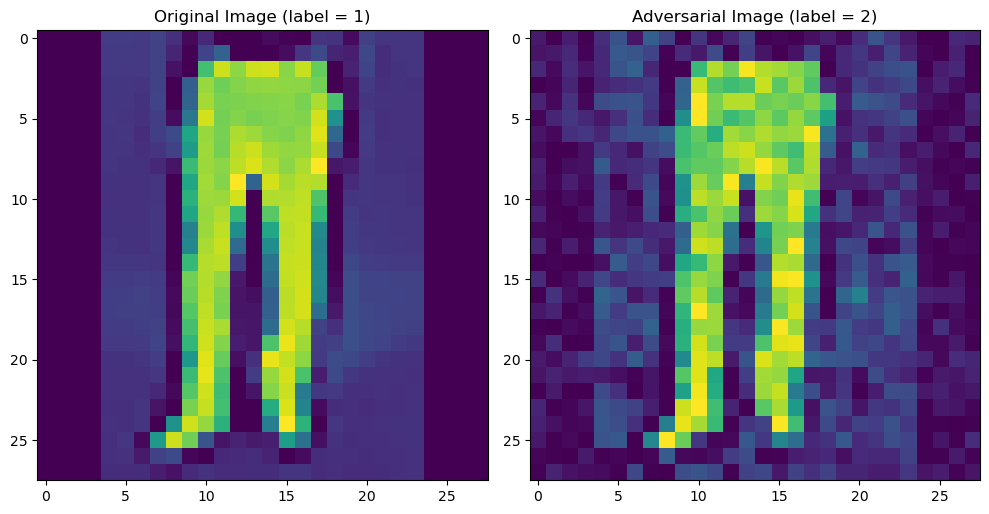

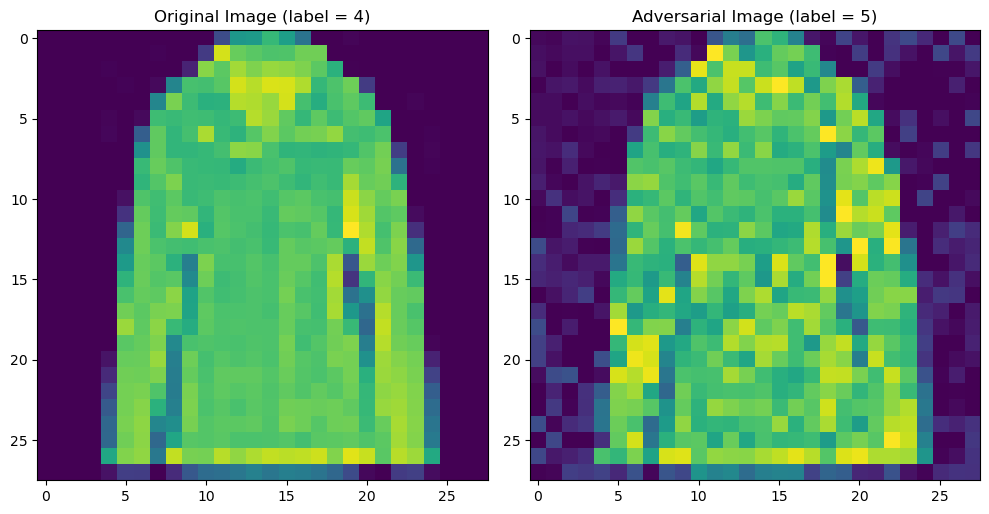

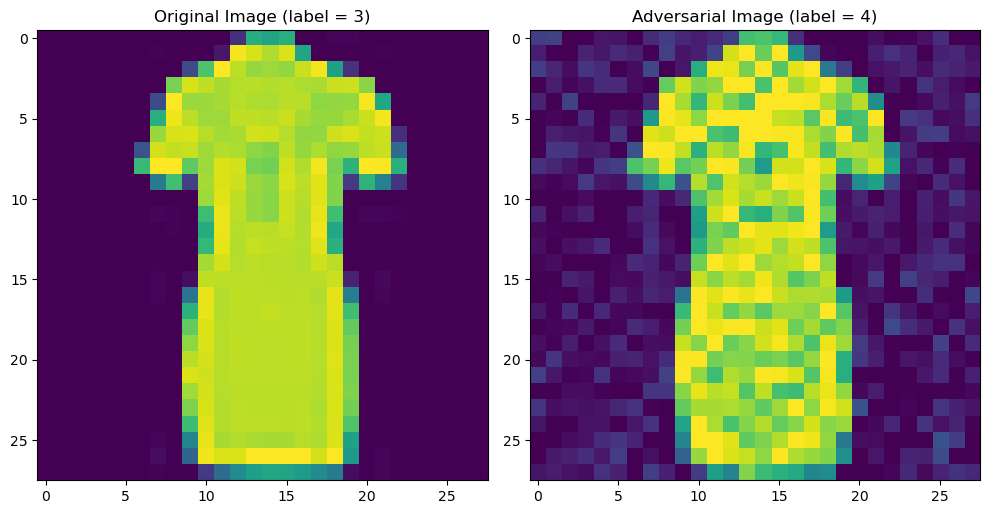

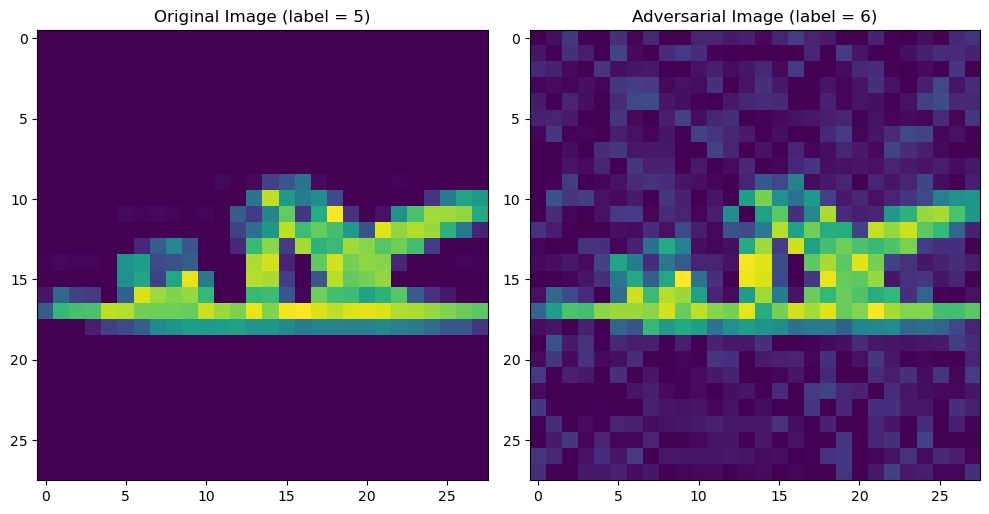

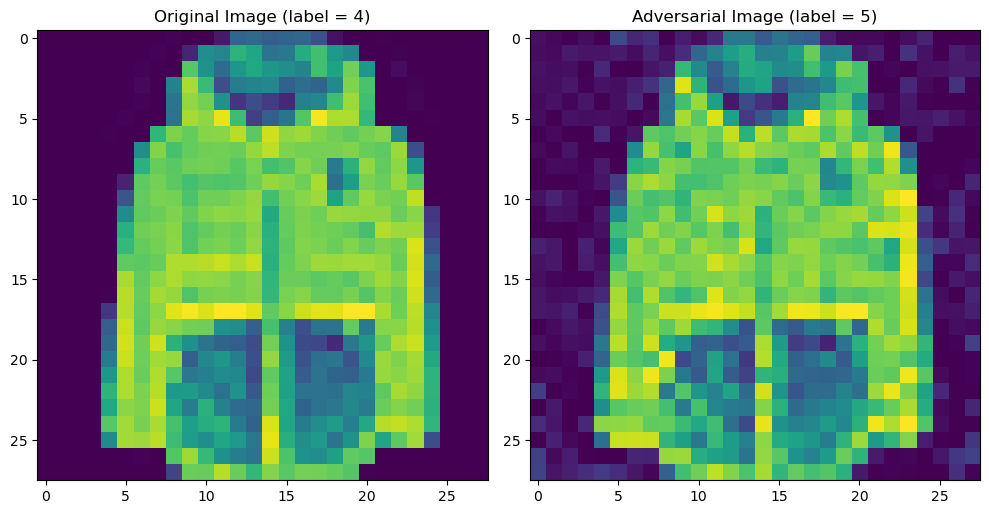

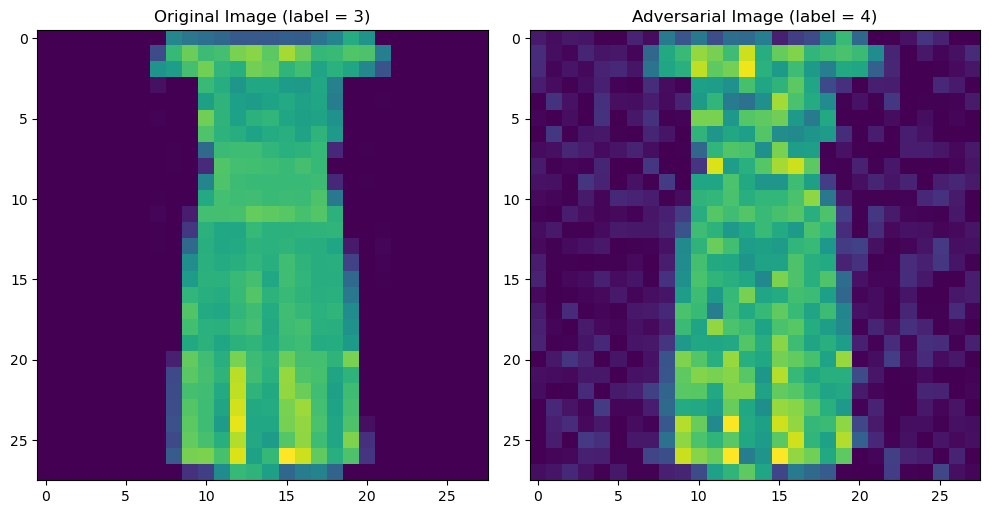

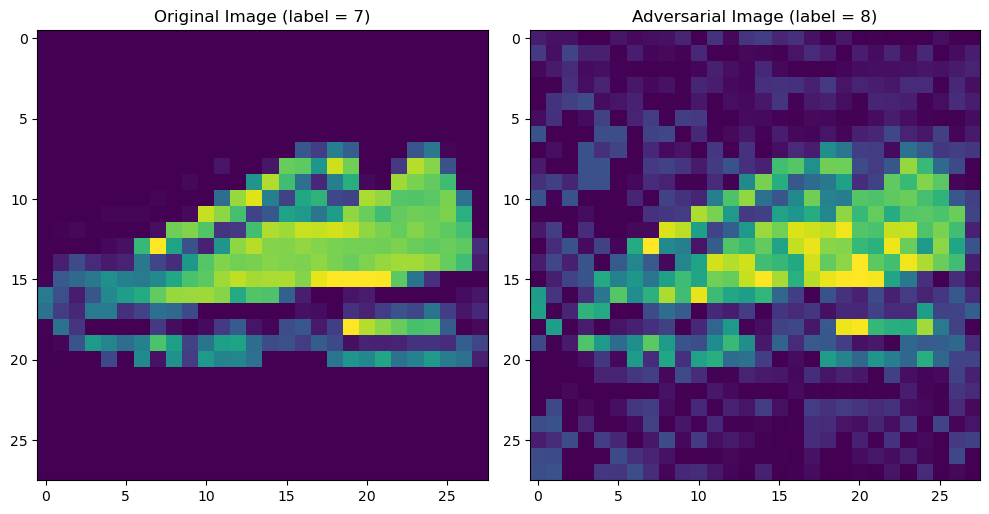

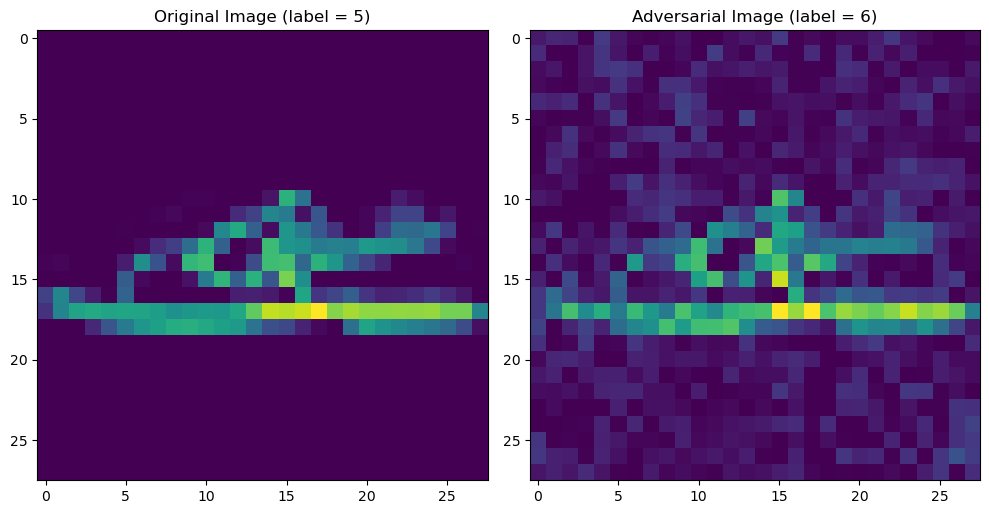

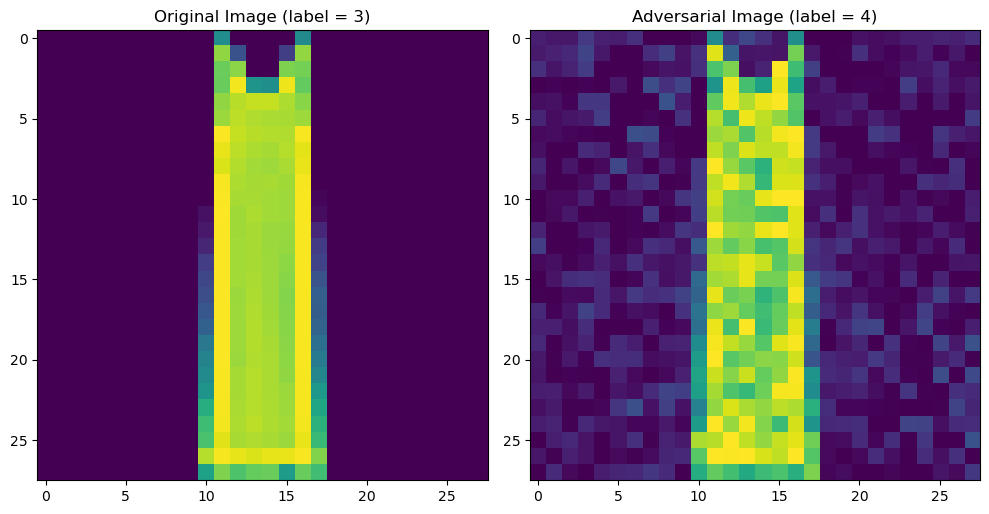

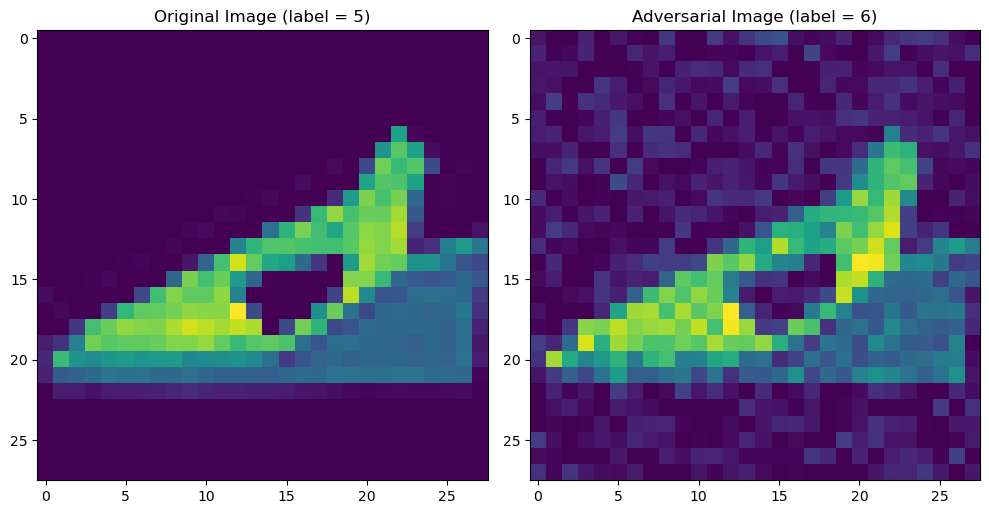

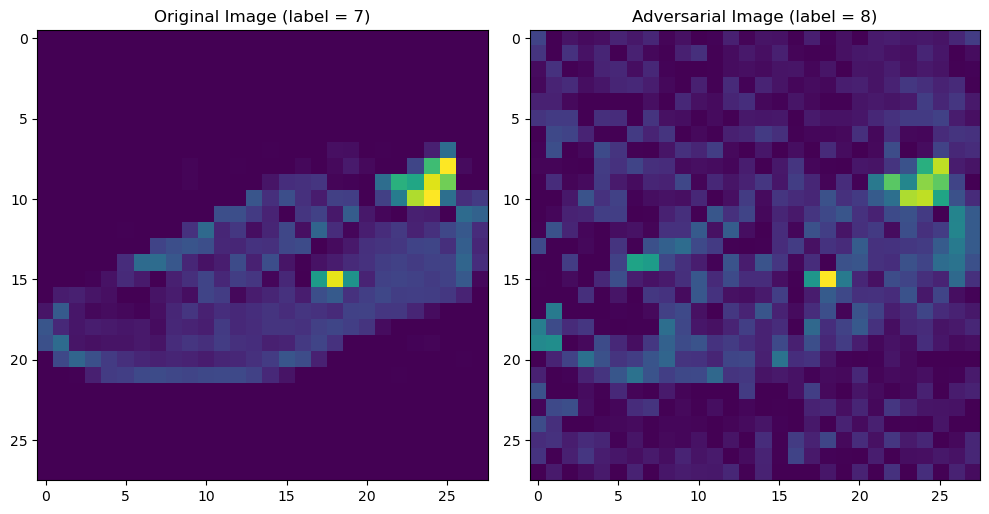

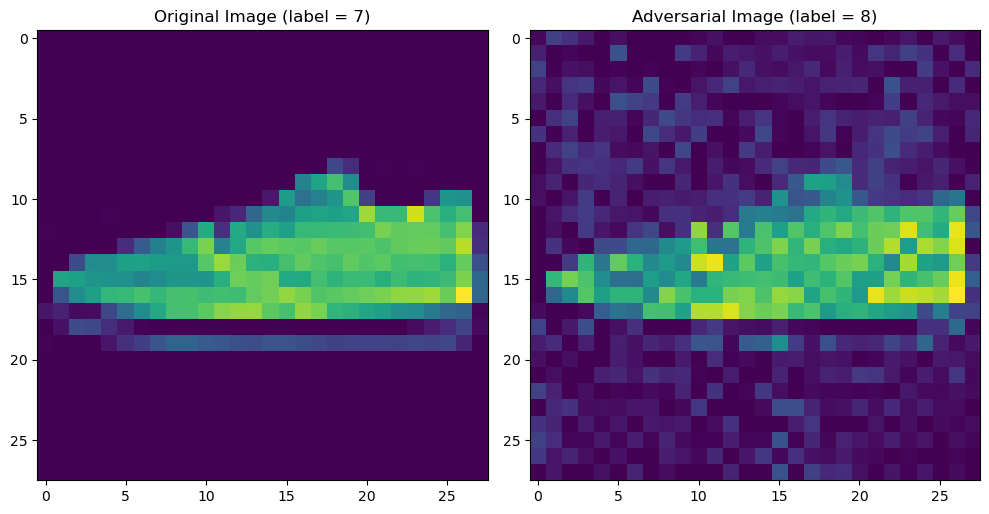

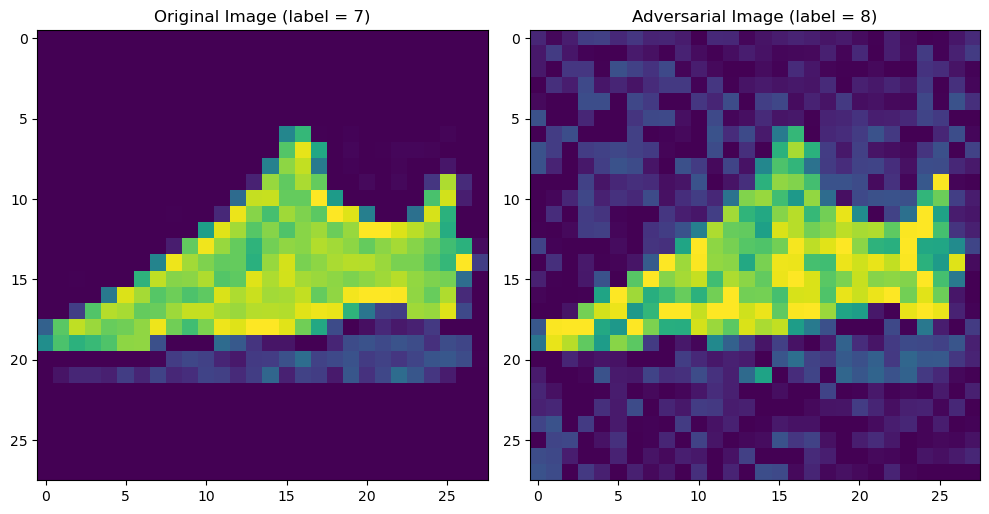

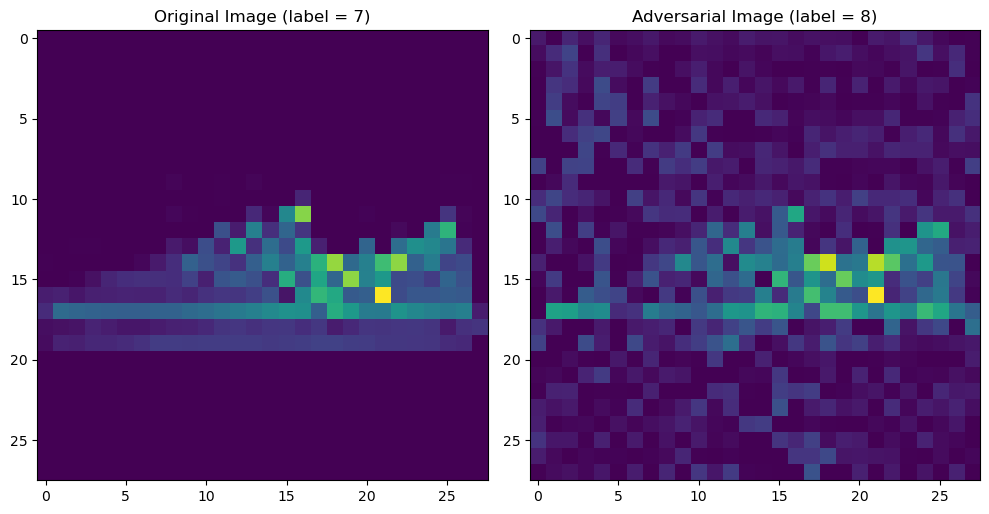

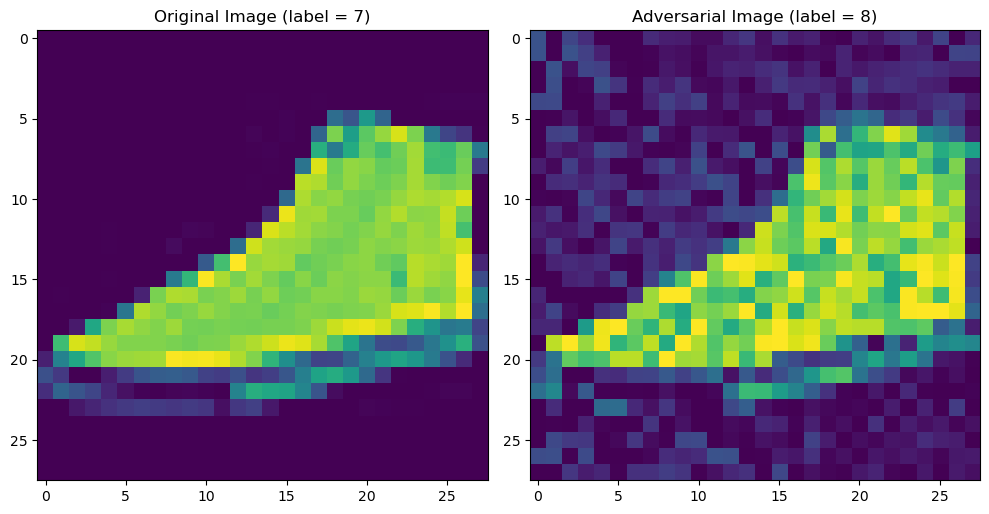

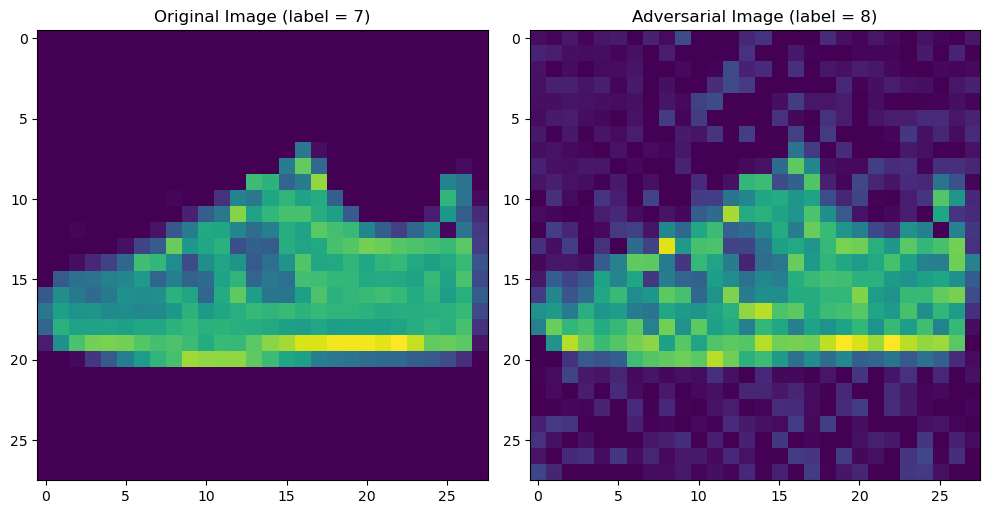

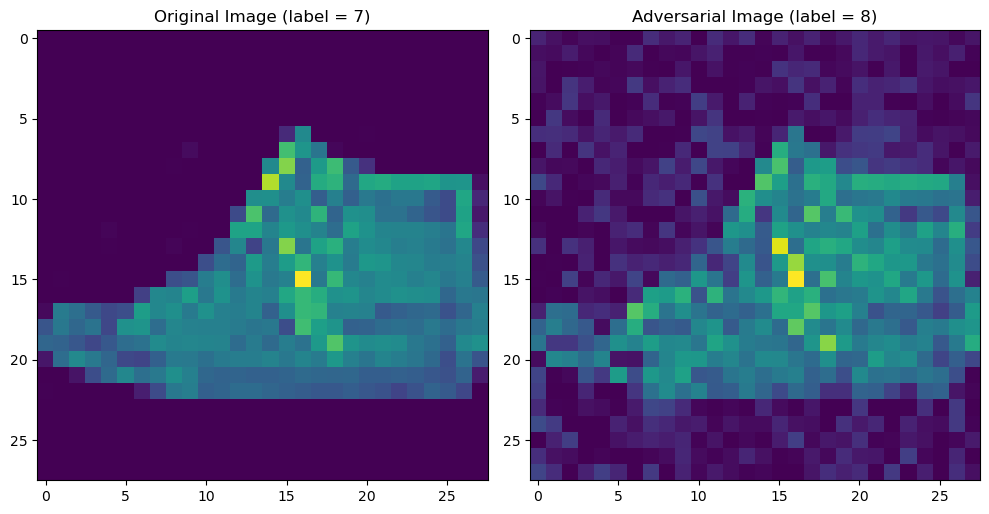

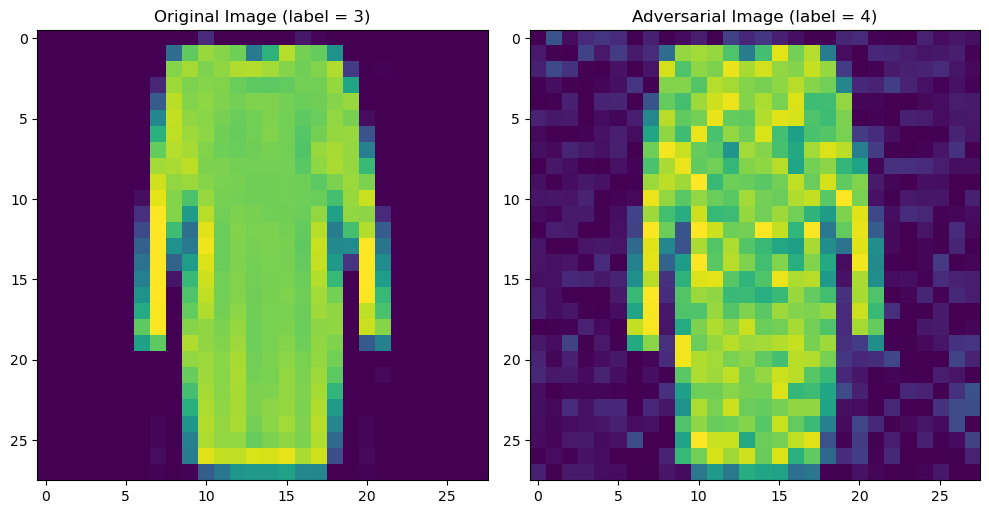

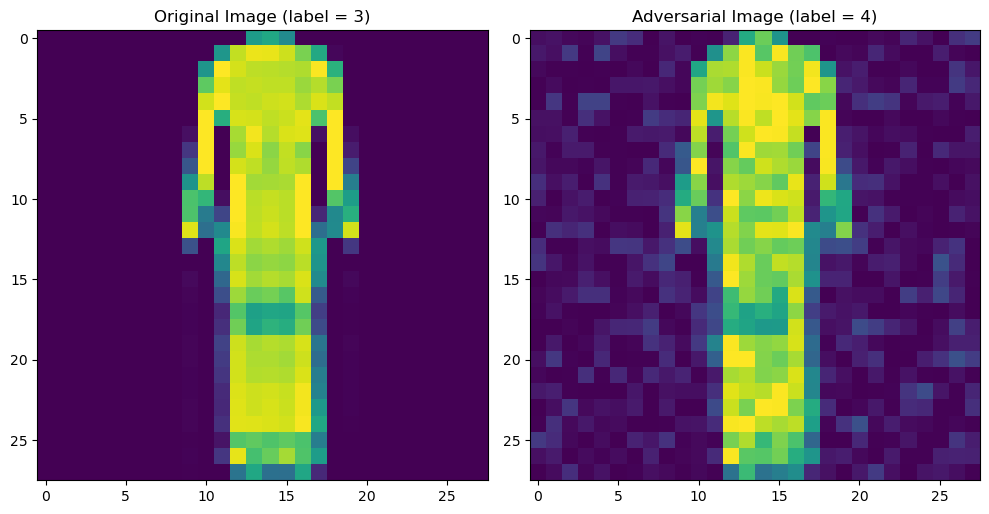

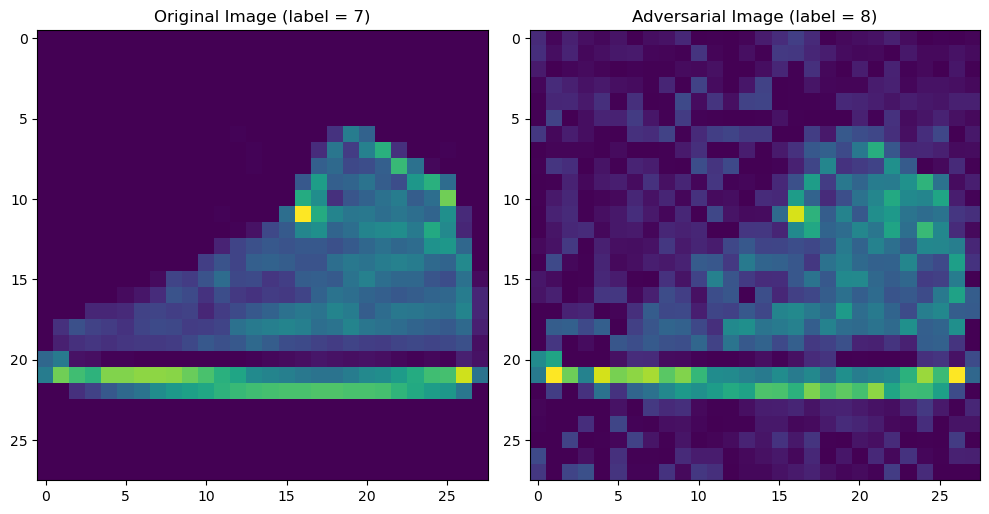

In [15]:
new_white_model = SimpleResNet().cuda()
checkpoint_path = 'new_resnet_checkpoints\ep_18_devacc_90.3_.pt'
new_white_model.load_state_dict(torch.load(checkpoint_path))
new_test_accuracy = evaluate(new_white_model, test_dataloader, 'cuda')
print("old {} classifier test accuracy: {:.3f}%    new {} classifier test accuracy: {:.3f}%    \improvement over accuracy: {:.3f}%"\
        .format(type(new_white_model).__name__, test_accuracy, type(new_white_model).__name__, new_test_accuracy, new_test_accuracy - test_accuracy))

new_attacker = WhiteBoxAttacker(new_white_model, epsilon=EPSILON, alpha=ALPHA)
x_correct, y_correct, x_adv, y_adv = generate_adversarial_examples(new_attacker, test_dataloader, example_n = 1000)
new_white_attack_success_rate, success_indicies = success_rate_with_examples(new_white_model, x_adv, y_adv, example_n = 10)
save_image(x_correct, y_correct, x_adv, y_adv, success_indicies, image_path='images/image_new_white_box', image_name='fmnist_white_box_attack_example')
print("old white attack success rate : {:.3f}%, new white attack success rate : {:.3f}%".format(white_attack_success_rate, new_white_attack_success_rate))
print("example images were saved successfully")
x_correct, y_correct, x_adv, y_adv = generate_adversarial_examples(new_attacker, blackbox_dataloader, example_n = None)
new_black_attack_success_rate, success_indicies = success_rate_with_examples(black_model, x_adv, y_adv, example_n = 10)
print("old black attack success rate : {:.3f}%, new black attack success rate : {:.3f}%".format(black_attack_success_rate, new_black_attack_success_rate))
save_image(x_correct, y_correct, x_adv, y_adv, success_indicies, image_path='images/image_new_black_box', image_name='fmnist_black_box_attack_example')
print("example images were saved successfully")